# Autoencoder demonstration of Fisher metric pruning:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
import autoencoder

/var/folders/91/t5gt4nr502vgy7gsbqgd47wm0000gn/T/ipykernel_12225/1800734416.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Train a degenerate autoencoder
__256 hidden neurons in latent space__

In [2]:
model = autoencoder.MNISTModel(latent_dim=20)
model.train()

Epochs: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Completed training successfully...


## Testing
__(check the performance of the encoder)__

In [3]:
# Define a transform to map from image to pixel floats
transform = transforms.Compose([transforms.ToTensor(), torch.flatten])

# Create testing dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

# Create testing dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=10, shuffle=True
)


In [4]:
import matplotlib.pyplot as plt

def plot_batch(images, filename):
    # Plot the batch of images
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].view(28, 28).detach().numpy(), cmap='gray')
        # plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [5]:
# Get a batch of images
iterator = iter(test_dataloader)
batches = next(iterator)
batch_0 = batches[0]

### Original images

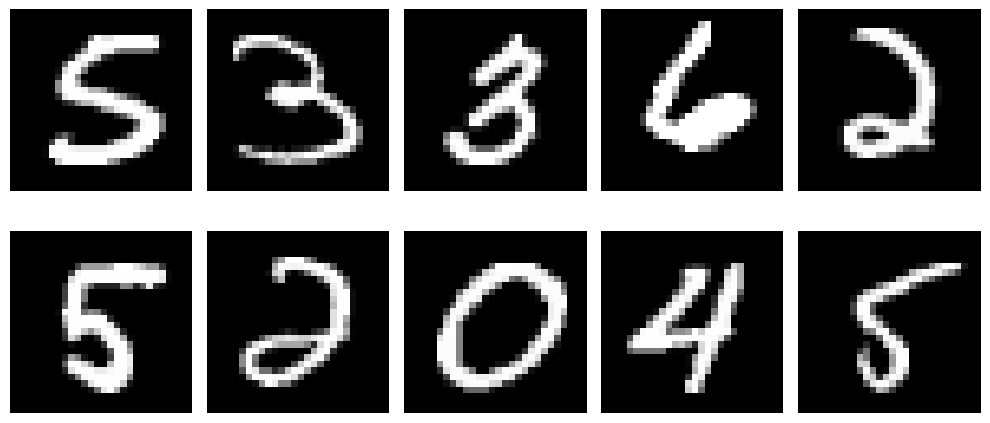

In [6]:
plot_batch(batch_0, filename='plots/original_samples.pdf')

In [7]:
autoencoded_batch = [model.autoencoder(batch_0[i]) for i in range(10)]

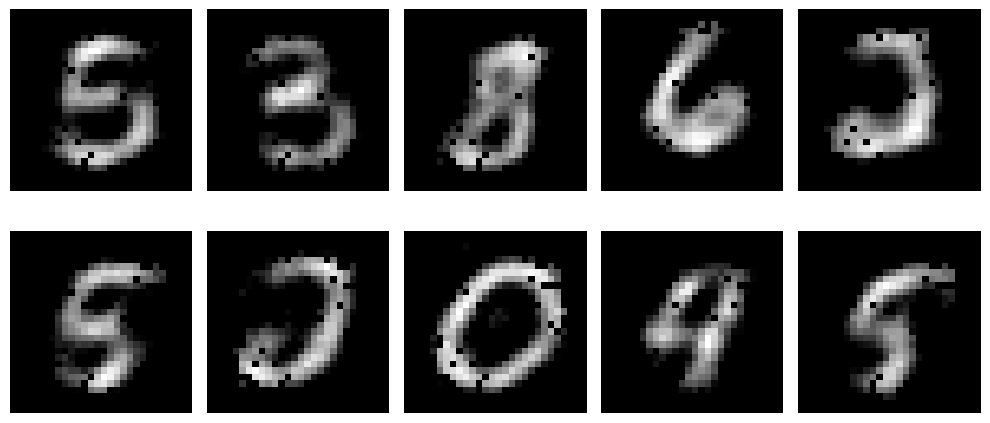

In [8]:
plot_batch(autoencoded_batch, 'plots/autoencoded_no_pruning.pdf')
# autoencoded_batch[0].shape

## Diagonal Fisher matrix element distribution

In [9]:
import fisher_transform
# Define the FIM
fim = fisher_transform.find_fisher(model.autoencoder, test_dataloader,
                                   n_output=784)


Autoencoder(
  (encoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=784, bias=True)
    (1): ReLU()
  )
)


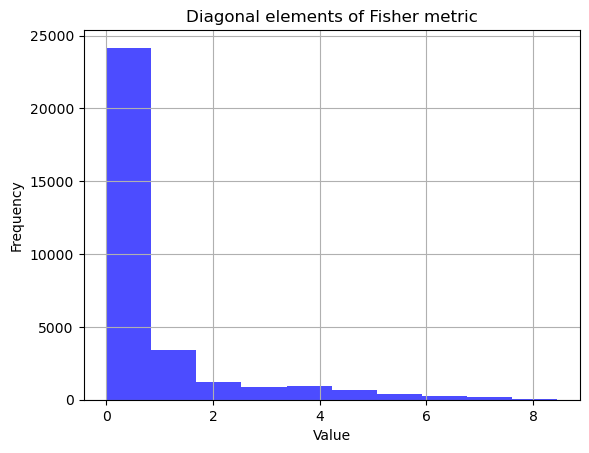

In [10]:
# Distribution of diagonal elements of FIM

# Plot the histogram
plt.hist(fim, bins=10, color='blue', alpha=0.7)
plt.title('Diagonal elements of Fisher metric')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('plots/hist_diag_elmts.pdf')
plt.show()

## Pruned metric plots

In [11]:
from nngeometry.object import PMatDiag, PMatDense
from nngeometry.metrics import FIM
from nngeometry.layercollection import LayerCollection
import copy

[15680 15700 31380 32164]
Removed 5496 params


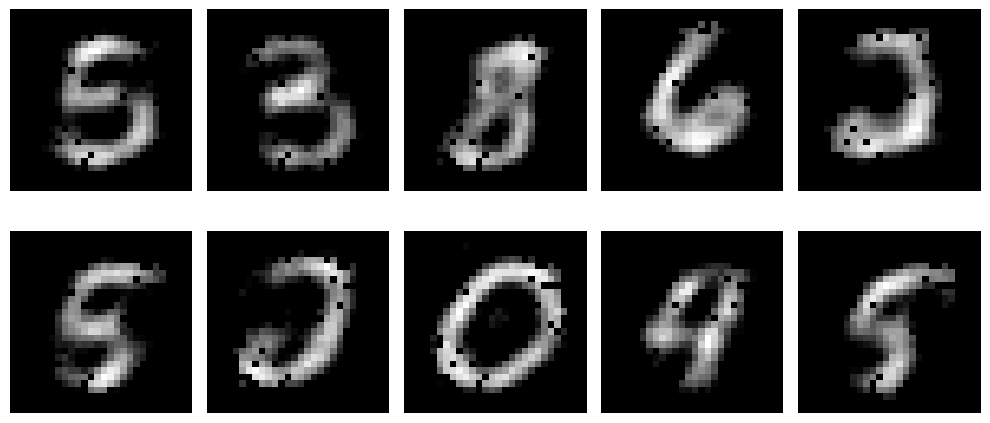

[15680 15700 31380 32164]
Removed 11689 params


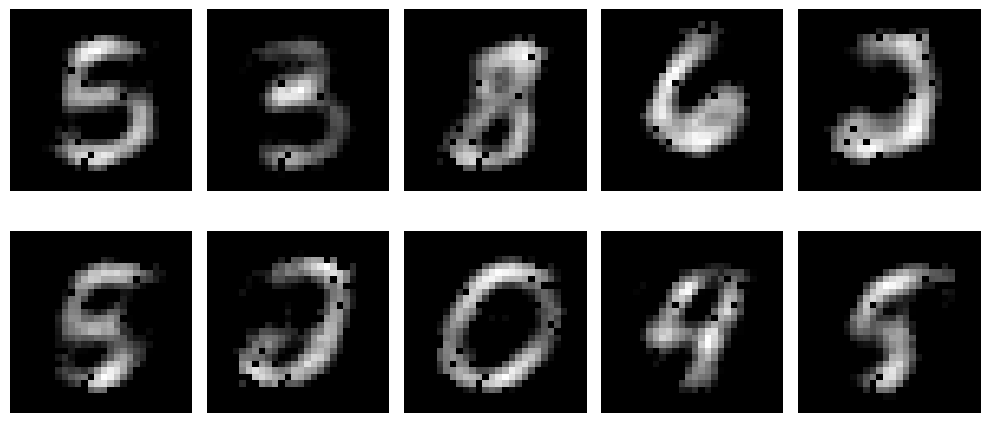

[15680 15700 31380 32164]
Removed 12979 params


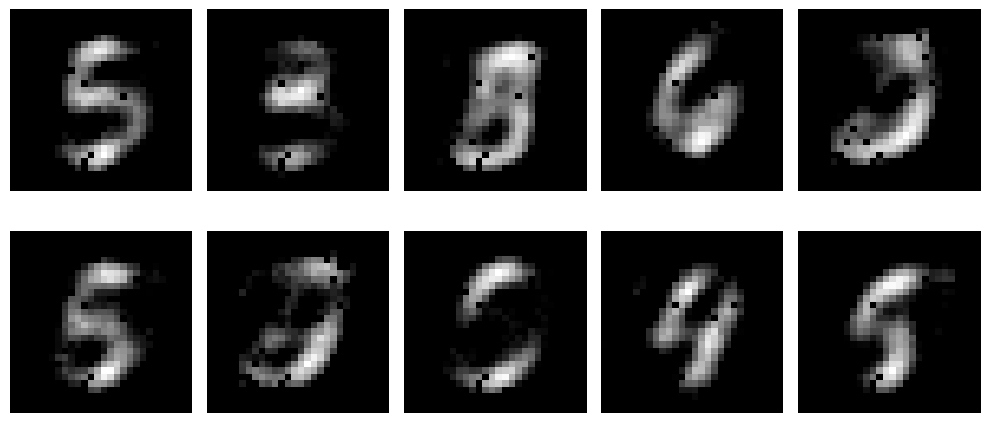

[15680 15700 31380 32164]
Removed 14744 params


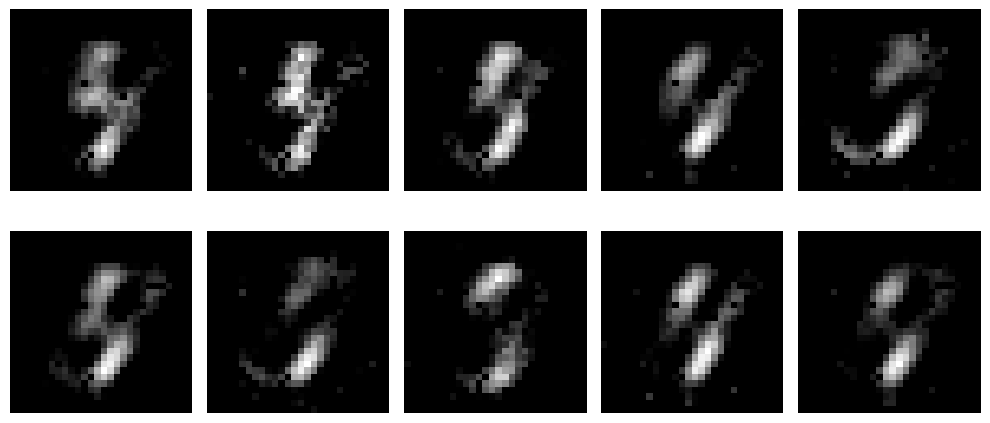

[15680 15700 31380 32164]
Removed 15615 params


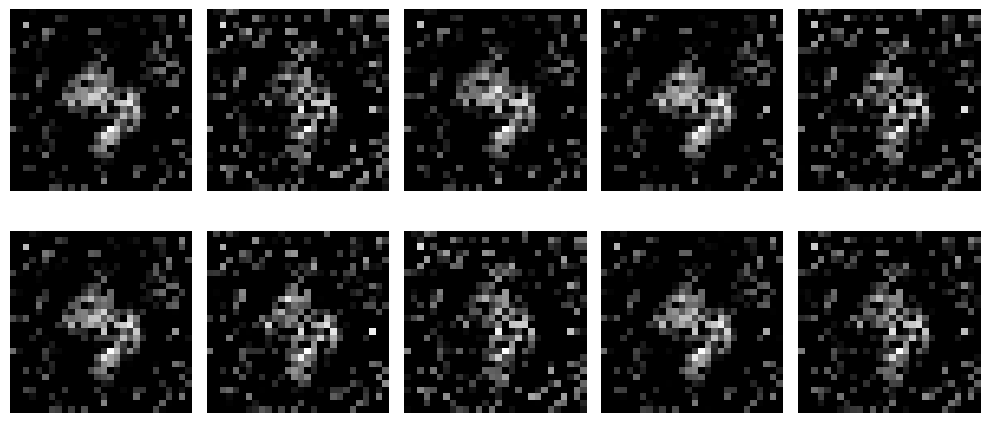

[15680 15700 31380 32164]
Removed 15680 params


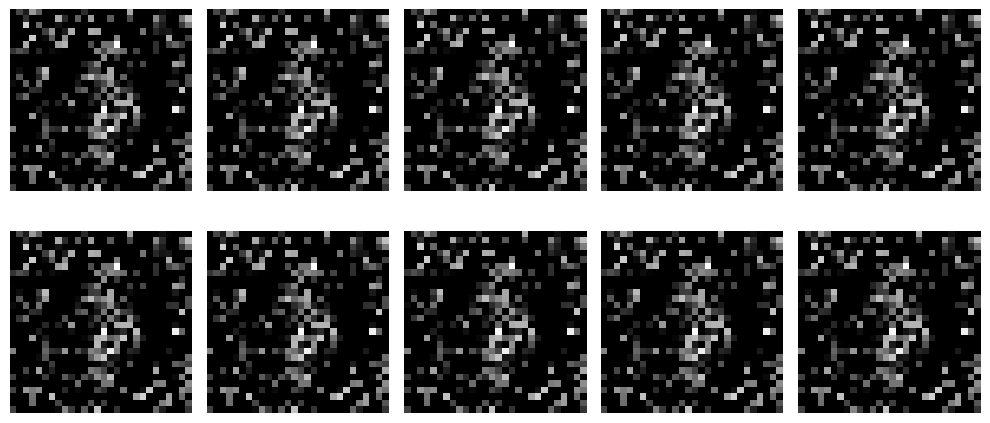

[15680 15700 31380 32164]
Removed 15680 params


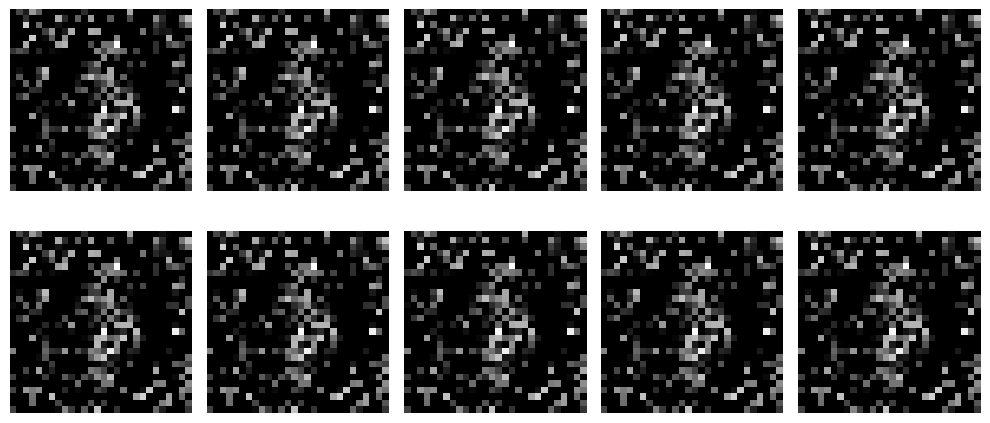

[15680 15700 31380 32164]
Removed 15680 params


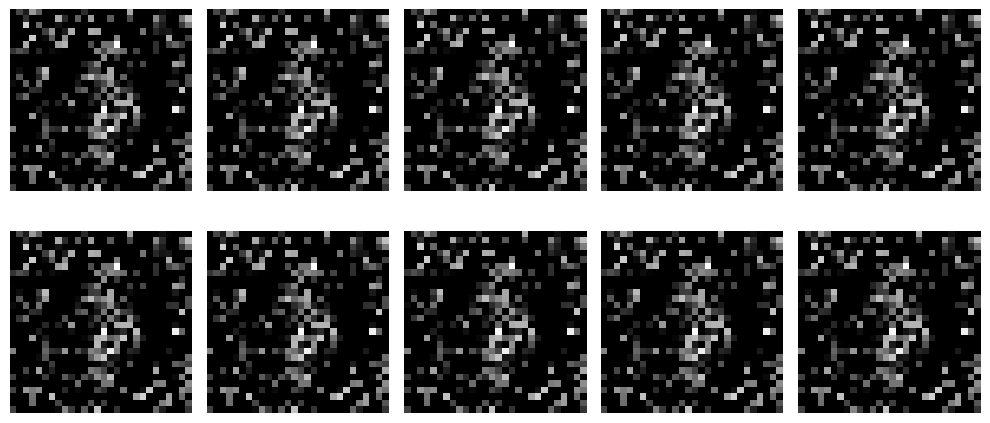

[15680 15700 31380 32164]
Removed 15680 params


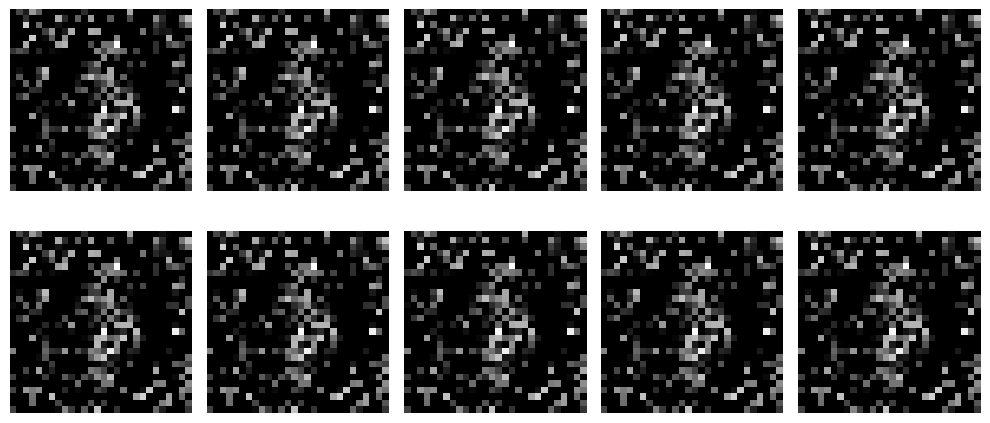

[15680 15700 31380 32164]
Removed 15680 params


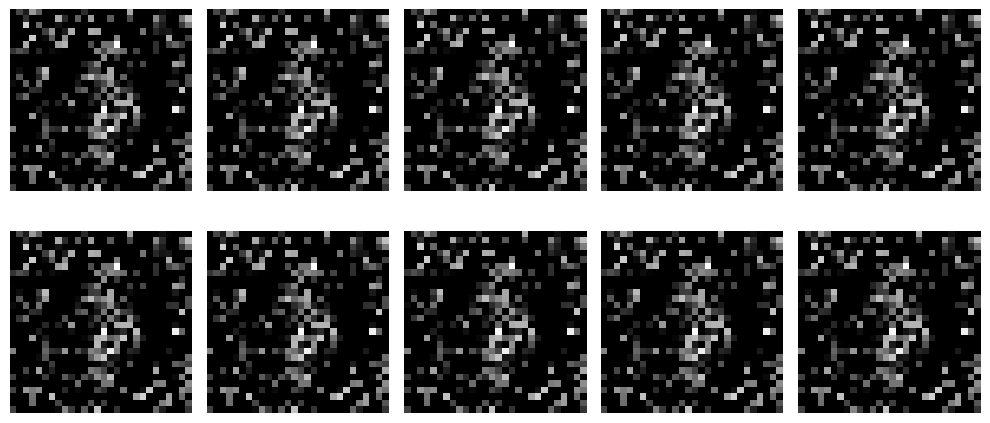

[15680 15700 31380 32164]
Removed 15680 params


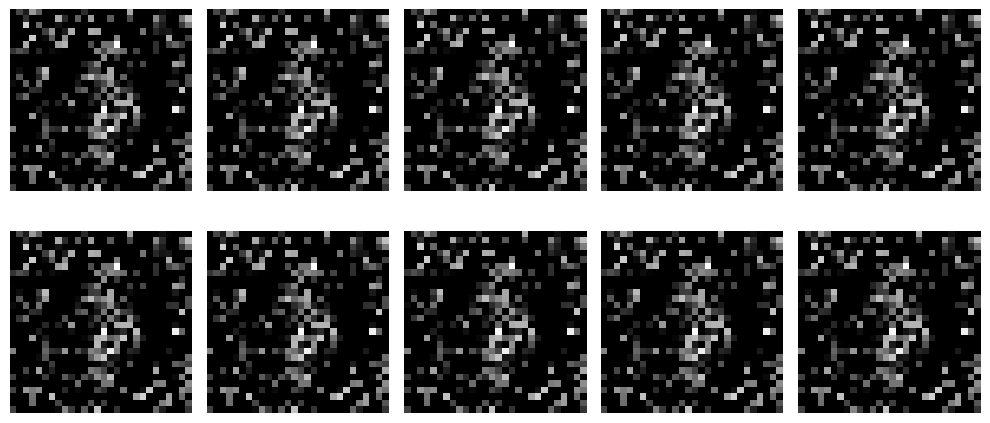

[15680 15700 31380 32164]
Removed 15680 params


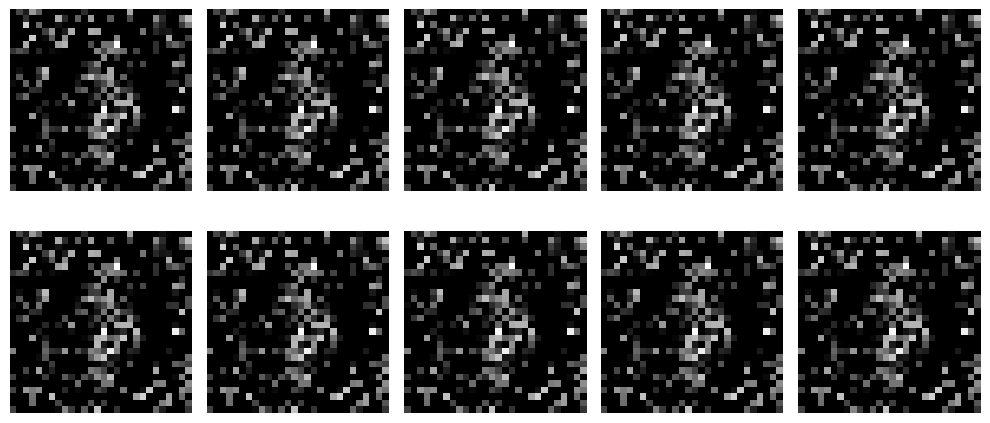

[15680 15700 31380 32164]
Removed 15680 params


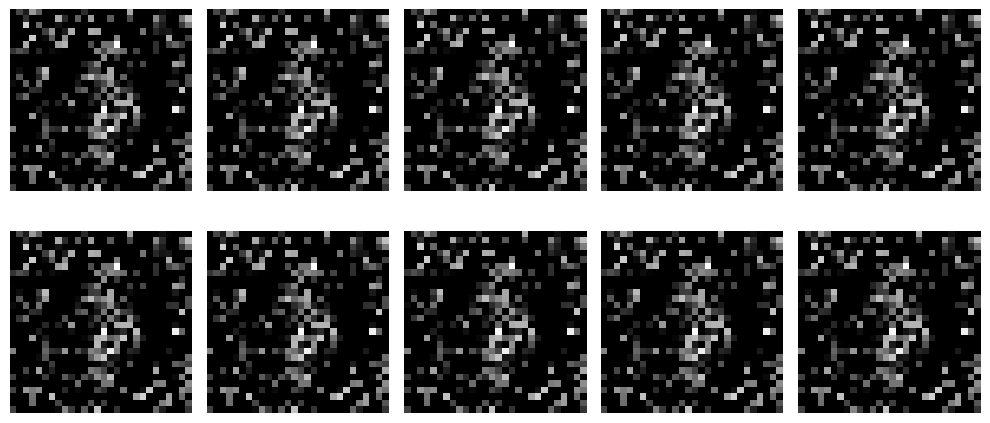

[15680 15700 31380 32164]
Removed 15680 params


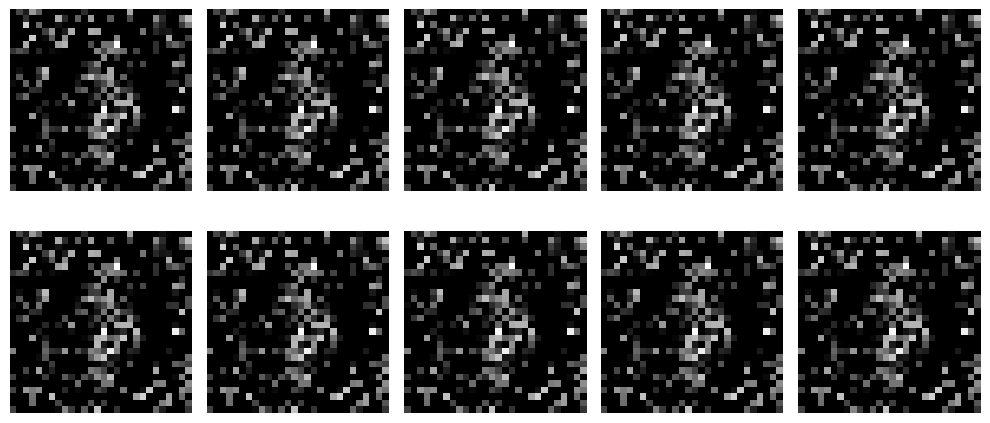

[15680 15700 31380 32164]
Removed 15680 params


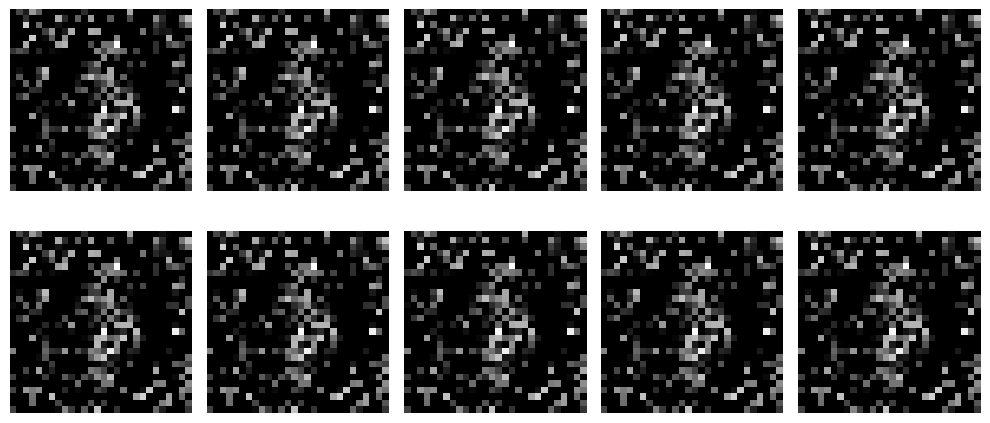

[15680 15700 31380 32164]
Removed 15680 params


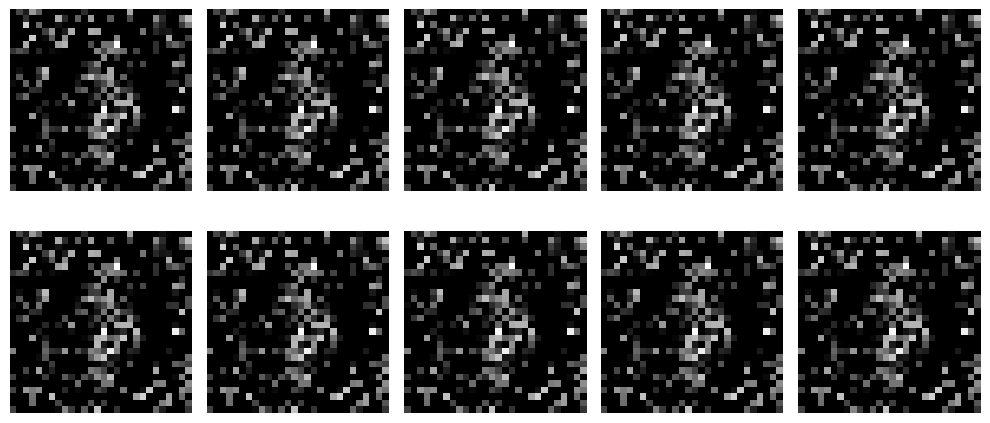

In [13]:
for cutoff in range(16):
    cutoff = cutoff/2
    # Create a backup of the original model before pruning
    model_clone = copy.deepcopy(model)
    sloppy_rows = fisher_transform.get_sloppy_rows(fim, model_clone.autoencoder, cutoff=cutoff)
    removed_number = fisher_transform.zero_sloppy_params(fim, sloppy_rows, model_clone.autoencoder)
    model_clone, removed_params = stiff_autoencoded_batch = [model_clone.autoencoder(batch_0[i]) for i in range(10)]
    plot_batch(stiff_autoencoded_batch, f'plots/autoencoded_stiff_cutoff_{cutoff}_rem_{removed_params}_of_1560_params.pdf')